In [71]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [72]:
sys.path.append('..')
from tlfair.metrics import *

In [88]:
rng = np.random.default_rng()
n = 100000
d = 15

x = rng.normal(size=(n,d))
g = (rng.uniform(size = (n,)) > 0.5).astype(np.int8)

for i in range(5):
    x[:,i] = x[:,i] + g

xt = x.copy()
for i in range(3,8):
    xt[:,i] = x[:,i]**2

xt[:,10:] = 0
beta = np.array([1, 3, 1, -3, 4, 1, -3, 4, 4, 1, 0, 0, 0, 0, 0])
y_probs = 1/(1+np.exp(-xt@beta))
y = (y_probs >= 0.5).astype(np.int8)

print(np.mean(y))
truth = np.mean(y_probs[g==1]) - np.mean(y_probs[g==0])
print(truth)

0.67419
0.14666353955854483


In [74]:
def robust_sim(
    n,
    propensity = LogisticRegression(solver='liblinear'),
    outcome = LogisticRegression(solver='liblinear')
):

    n = n // 2
    d = 15
    x = rng.normal(size=(2*n,d))
    g = (rng.uniform(size = (2*n,)) > 0.5).astype(np.int8)

    for i in range(5):
        x[:,i] = x[:,i] + g

    xt = x.copy()
    for i in range(3,8):
        xt[:,i] = x[:,i]**2

    xt[:,10:] = 0
    beta = np.array([1, 3, 1, -3, 4, 1, -3, 4, 4, 1, 0, 0, 0, 0, 0])
    y_probs = 1/(1+np.exp(-xt@beta))
    y = (y_probs >= 0.5).astype(np.int8)

    test = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        outcome = outcome,
        propensity = propensity,
        )
    return test[0], 


0.011513691237741158


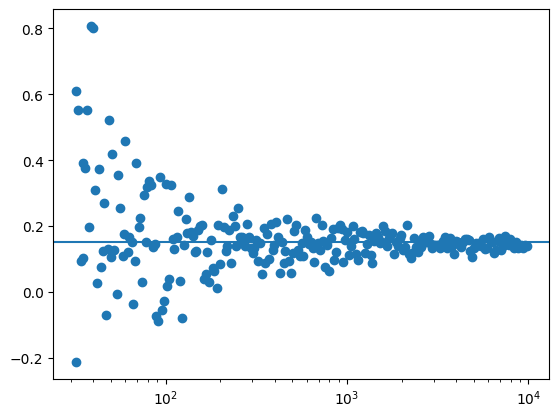

In [77]:
# both logistic
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
res = []
for i in range(len(sample_sizes)):
    res.append(robust_sim(sample_sizes[i]))

print(np.mean(np.array(res) - truth))
plt.scatter(sample_sizes, res)
plt.xscale('log')
plt.axhline(np.mean(y_probs[g==1]) - np.mean(y_probs[g==0]))

-0.0007362036202463478


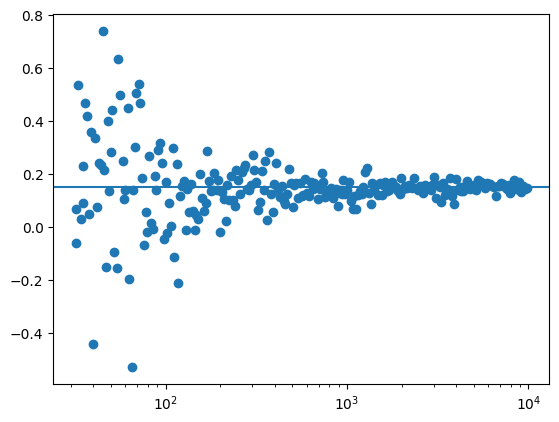

In [79]:
# outcome logistic, propensity boosting
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
res = []
for i in range(len(sample_sizes)):
    res.append(robust_sim(sample_sizes[i],
    propensity = GradientBoostingClassifier()) )

print(np.mean(np.array(res) - truth))
plt.scatter(sample_sizes, res)
plt.xscale('log')
plt.axhline(np.mean(y_probs[g==1]) - np.mean(y_probs[g==0]))

-0.011092689660525684


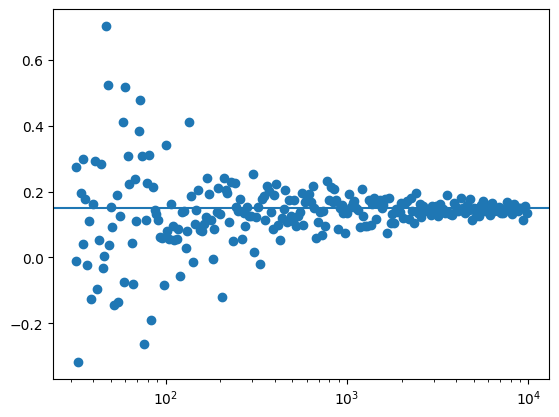

In [80]:
# outcome boosting, propensity logistic
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
res = []
for i in range(len(sample_sizes)):
    res.append(robust_sim(sample_sizes[i],
    outcome = GradientBoostingClassifier()) )

print(np.mean(np.array(res) - truth))
plt.scatter(sample_sizes, res)
plt.xscale('log')
plt.axhline(np.mean(y_probs[g==1]) - np.mean(y_probs[g==0]))